<a href="https://colab.research.google.com/github/cdac-int-project/Community-Detection-In-Social-Network/blob/main/Algorithms/Leiden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Leiden***

In [85]:
!pip install leidenalg
!pip install igraph

In [86]:
import pandas as pd
import networkx as nx
import community.community_louvain as cl
import matplotlib.pyplot as plt
import random
import leidenalg as la
import igraph as ig
import sys
from matplotlib.patches import Ellipse

In [87]:
# Load the data from CSV
file_path = 'call_records.csv'  # Replace with your file path
try:
    df = pd.read_csv(file_path)
    print(df.head())
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the file path.")
    sys.exit(1)
except pd.errors.ParserError:
    print(f"Error: Could not parse the CSV file. Please ensure it is properly formatted.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    sys.exit(1)

   Calling Party  Called Party             IMEI             IMSI   Call Date  \
0     7806566906    7138293654   62562145495284  718316146034816  2024-08-13   
1     8581916045    8366256065   56867908299113  137911514839499  2024-05-07   
2     8546153259    7028705640  230776734184963  700140413585133  2024-10-25   
3     7982574554    8754470786  135125722662329  161145201063753  2024-11-26   
4     7028705640    8566239944  253463756543498    5803058135918  2024-10-11   

  Call Type Start Time  End Time  Duration (seconds)  
0    SMS In   06:25:50       NaN                   0  
1    SMS In   23:11:17       NaN                   0  
2  Voice In   00:57:08  02:16:59                4791  
3    SMS In   23:11:24       NaN                   0  
4  Voice In   18:44:51  19:21:41                2210  


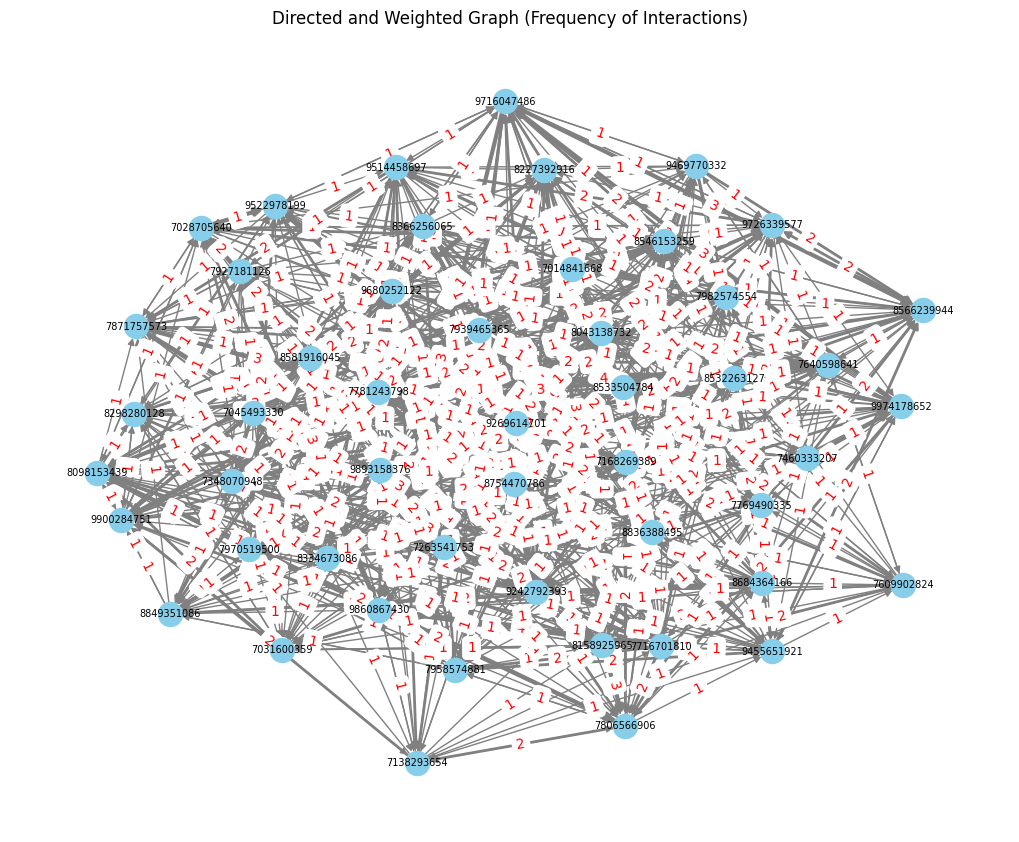

In [88]:
# Creating a Directed Graph (weighted by frequency of calls or SMS)
G = nx.DiGraph()

try:
    # Compute frequency of interactions (calls + SMS) between each pair
    interaction_counts = df.groupby(['Calling Party', 'Called Party']).size().reset_index(name='Frequency')

    # Adding directed edges with frequency as weights
    for _, row in interaction_counts.iterrows():
        G.add_edge(row['Calling Party'], row['Called Party'], weight=row['Frequency'])

    # Removing self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Visualizing the graph
    plt.figure(figsize=(10, 8))
    random.seed(50)
    pos = nx.kamada_kawai_layout(G)  # Position nodes using a force-directed algorithm
    weights = nx.get_edge_attributes(G, 'weight')

    # Create a list of edge widths based on weights
    widths = [weights[edge] for edge in G.edges()]

    # Draw the graph with varying edge widths
    nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray", font_size=7, width=widths)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color="red")
    plt.title("Directed and Weighted Graph (Frequency of Interactions)")
    plt.show()

except KeyError as e:
    print(f"Error: Missing column in your CSV file: {e}. Please ensure 'Calling Party', 'Called Party', and 'Frequency' columns are present.")
    sys.exit(1)
except (TypeError, ValueError) as e:
    print(f"Error: Data type mismatch or unexpected value: {e}. Please check the data in your CSV file.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during graph creation: {e}")
    sys.exit(1)

In [89]:
# Converting NetworkX graph to igraph, including weights
try:
    edge_list = [(u, v, G[u][v]['weight']) for u, v in G.edges()]  # Include weights in edge list
except KeyError:
    print("Error: 'weight' attribute not found on all edges. Ensure all edges have weights.")
    sys.exit(1)  # Exit with error code 1
except Exception as e:
    print(f"An unexpected error occurred during edge list creation: {e}")
    sys.exit(1)

# Creating the igraph graph
try:
    ig_graph = ig.Graph.TupleList(edge_list, directed=True, edge_attrs=['weight'])  # Specify edge attribute
except Exception as e:
    print(f"Error creating igraph graph: {e}")
    sys.exit(1)

In [90]:
# Optimizing the graph with Leiden algorithm (using weights)
try:
    partition_leiden = la.find_partition(ig_graph, la.ModularityVertexPartition, weights='weight')  # Use weights
except Exception as e:
    print(f"Error during Leiden algorithm execution: {e}")
    sys.exit(1)

# Getting the communities from the Leiden algorithm
try:
    partition = {}
    for i, node in enumerate(ig_graph.vs):
        partition[node["name"]] = partition_leiden.membership[i]
except Exception as e:
    print(f"Error extracting communities from Leiden results: {e}")
    sys.exit(1)

# Computing the modularity score
try:
    modularity_score = partition_leiden.modularity
    print(f"Modularity Score : {modularity_score}")
except AttributeError:
    print("Error: 'modularity' attribute not found in Leiden results.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred while computing modularity: {e}")
    sys.exit(1)

Modularity Score : 0.10707365726975043


<ipython-input-91-0124b5c8642c>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', num_communities)
/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


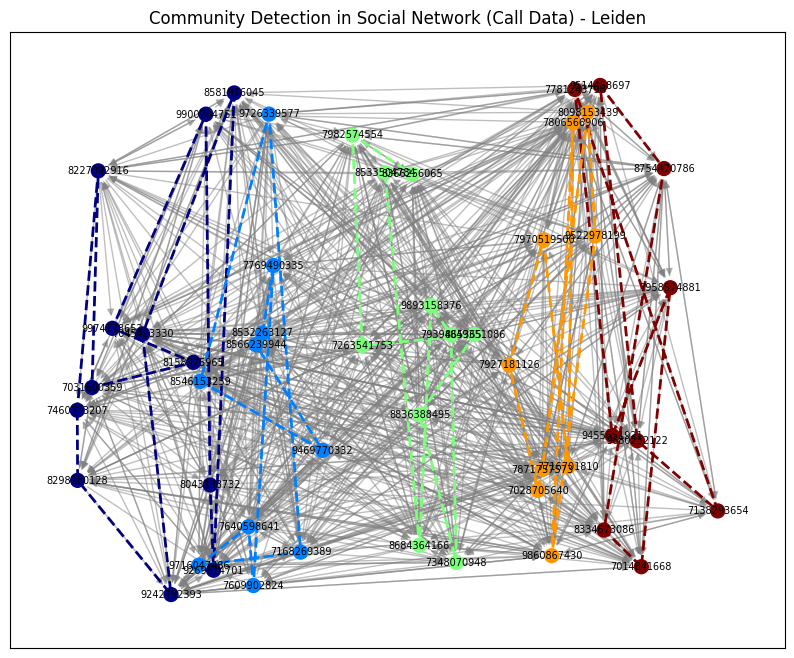

In [91]:
# Visualize the communities with improved layout
try:
    plt.figure(figsize=(10, 8))

    # Group nodes by community, starting from Community 1
    communities = {}
    for node, community_id in partition.items():
        # Adding 1 to the community_id to start from 1
        adjusted_community_id = community_id + 1

        if adjusted_community_id not in communities:
            communities[adjusted_community_id] = []
        communities[adjusted_community_id].append(node)

    # Adjusting positions within communities to gather nodes together
    adjusted_pos = {}

    # Increasing the proximity between nodes of the same community
    for community_id, nodes in communities.items():
        x_pos = [random.uniform(-1, 1) for _ in nodes]
        y_pos = [random.uniform(-1, 1) for _ in nodes]
        for node, x, y in zip(nodes, x_pos, y_pos):
            adjusted_pos[node] = (x + community_id * 1.5, y)

    # Nodes colored by community
    num_communities = len(communities)
    cmap = plt.cm.get_cmap('jet', num_communities)
    colors = [cmap(partition[node]) for node in G.nodes()]

    nx.draw_networkx_nodes(G, adjusted_pos, node_color=colors, cmap=plt.cm.jet, node_size=100)

    # Draw directed edges
    nx.draw_networkx_edges(G, adjusted_pos, alpha=0.5, edgelist=G.edges(), arrows=True, edge_color="grey")

    # Draw node labels
    nx.draw_networkx_labels(G, adjusted_pos, font_size=7, font_color="black")

    # Add community borders
    for community_id, nodes in communities.items():
        community_pos = [adjusted_pos[node] for node in nodes]
        x_coords, y_coords = zip(*community_pos)

        if nodes:
            try:
                node_index = list(G.nodes()).index(nodes[0])
                community_color = colors[node_index]
            except ValueError:
                community_color = 'black'
        else:
            community_color = 'black'

        line_style = '--'

        plt.gca().add_patch(plt.Polygon(list(zip(x_coords, y_coords)),
                                       fill=None,
                                       edgecolor=community_color,
                                       linestyle=line_style,
                                       lw=2))

    plt.title("Community Detection in Social Network (Call Data) - Leiden")
    plt.show()

except Exception as e:
    print(f"An error occurred during visualization: {e}")
    sys.exit(1)

<ipython-input-92-e854ccc3e8aa>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', num_communities)


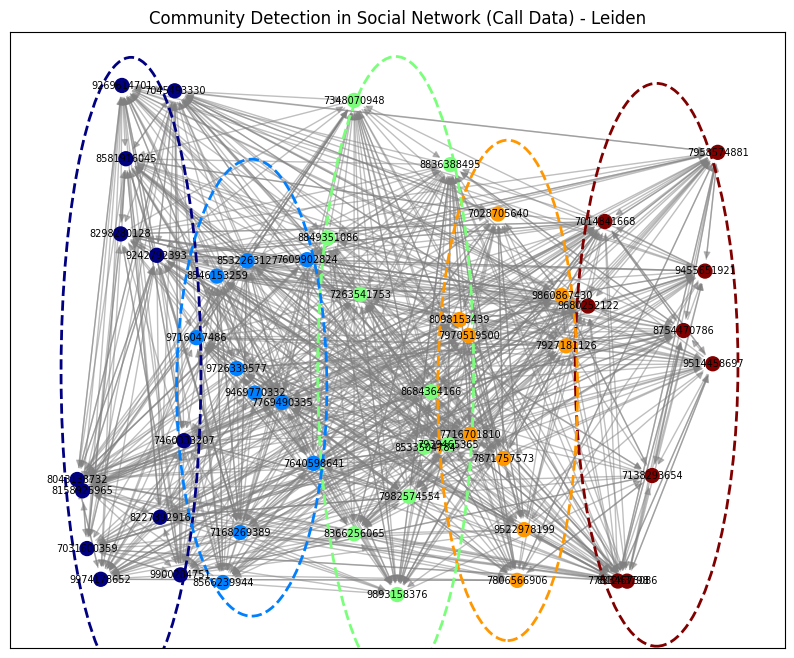

In [92]:
# Visualizing the communities with improved layout
try:
    plt.figure(figsize=(10, 8))

    # Group nodes by community, starting from Community 1
    communities = {}
    for node, community_id in partition.items():
        # Add 1 to the community_id to start from 1 instead of 0
        adjusted_community_id = community_id + 1

        if adjusted_community_id not in communities:
            communities[adjusted_community_id] = []
        communities[adjusted_community_id].append(node)

    # Adjust positions within communities to gather nodes together
    adjusted_pos = {}

    # Increase the proximity between nodes of the same community
    for community_id, nodes in communities.items():
        x_pos = [random.uniform(-1, 1) for _ in nodes]
        y_pos = [random.uniform(-1, 1) for _ in nodes]
        for node, x, y in zip(nodes, x_pos, y_pos):
            adjusted_pos[node] = (x + community_id * 2, y)

    # Nodes colored by community
    num_communities = len(communities)
    cmap = plt.cm.get_cmap('jet', num_communities)
    colors = [cmap(partition[node]) for node in G.nodes()]

    nx.draw_networkx_nodes(G, adjusted_pos, node_color=colors, cmap=plt.cm.jet, node_size=100)

    # Draw directed edges
    nx.draw_networkx_edges(G, adjusted_pos, alpha=0.5, edgelist=G.edges(), arrows=True, edge_color="grey")

    # Draw node labels
    nx.draw_networkx_labels(G, adjusted_pos, font_size=7, font_color="black")

    # Add community borders (using Ellipse for oval/circular shapes)
    for community_id, nodes in communities.items():
        # Get positions of nodes in this community
        community_pos = [adjusted_pos[node] for node in nodes]
        x_coords, y_coords = zip(*community_pos)

        # Calculate center and size of the ellipse
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        width = max(x_coords) - min(x_coords) + 0.5  # Adjust +0.5 for padding
        height = max(y_coords) - min(y_coords) + 0.5  # Adjust +0.5 for padding

        # Get community color (same logic as before)
        if nodes:
            try:
                node_index = list(G.nodes()).index(nodes[0])
                community_color = colors[node_index]
            except ValueError:
                community_color = 'black'
        else:
            community_color = 'black'

        # Create an Ellipse patch
        ellipse = Ellipse(xy=(center_x, center_y), width=width, height=height,
                          edgecolor=community_color, facecolor='none', linestyle='--', lw=2)

        # Add the ellipse to the plot
        plt.gca().add_patch(ellipse)

    plt.title("Community Detection in Social Network (Call Data) - Leiden")
    plt.show()

except Exception as e:
    print(f"An error occurred during visualization: {e}")
    sys.exit(1)  # Exit with an error code

In [93]:
# Displaying the detected communities in sorted order
print(f"Modularity Score: {modularity_score}")
print("Detected Communities (Leiden):")
try:
    for community_id in sorted(communities.keys()):
        members = sorted(communities[community_id])
        print(f"Community {community_id}: {members}")
except KeyError as e:
    print(f"Error: Community ID not found: {e}")
except TypeError as e:
    print(f"Error: Invalid community structure: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Modularity Score: 0.10707365726975043
Detected Communities (Leiden):
Community 1: [7031600359, 7045493330, 7460333207, 8043138732, 8158925965, 8227392916, 8298280128, 8581916045, 9242792393, 9269614701, 9900284751, 9974178652]
Community 2: [7168269389, 7609902824, 7640598641, 7769490335, 8532263127, 8546153259, 8566239944, 9469770332, 9716047486, 9726339577]
Community 3: [7263541753, 7348070948, 7939465365, 7982574554, 8366256065, 8533504784, 8684364166, 8836388495, 8849351086, 9893158376]
Community 4: [7028705640, 7716701810, 7806566906, 7871757573, 7927181126, 7970519500, 8098153439, 9522978199, 9860867430]
Community 5: [7014841668, 7138293654, 7781243798, 7958574881, 8334673086, 8754470786, 9455651921, 9514458697, 9680252122]


In [94]:
def get_common_community(communities, num1, num2):
    try:
        num1_community = None
        num2_community = None

        # Find the community for each number
        for community_id, mob in communities.items():
            if num1 in mob:
                num1_community = community_id
            if num2 in mob:
                num2_community = community_id

        # Check if both numbers are in the same community
        if num1_community == num2_community and num1_community is not None:
            print(f"Numbers {num1} and {num2} belong to the same community (Community {num1_community}).")
            return num1_community  # Same Community
        else:
            print(f"Numbers {num1} and {num2} belong to different communities.")
            if num1_community is not None:
                print(f"Number {num1} is in Community {num1_community}.")
            else:
                print(f"Number {num1} was not found in any community.")
            if num2_community is not None:
                print(f"Number {num2} is in Community {num2_community}.")
            else:
                print(f"Number {num2} was not found in any community.")
            return None  # Different Communities

    except (TypeError, KeyError) as e:
        print(f"Error: Invalid input or community structure: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

while True:
    try:
        num1 = int(input("Enter the first number: "))
        num2 = int(input("Enter the second number: "))
        break
    except ValueError:
        print("Error: Invalid input. Please enter numbers only.")
    except Exception as e:
        print(f"An unexpected error occurred during input: {e}")

print(f"Number 1: {num1}")
print(f"Number 2: {num2}")
call = get_common_community(communities, num1, num2)

Enter the first number: 7168269389
Enter the second number: 7168269389
Number 1: 7168269389
Number 2: 7168269389
Numbers 7168269389 and 7168269389 belong to the same community (Community 2).
